# TP CNN

### Martiros Yeghiazaryan

## Introduction


In [1]:
%pip install tensorflow_addons # install tensorflow_addons
from tensorflow_addons.metrics import F1Score

from IPython.display import Image
import tensorflow as tf

print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import ConfusionMatrixDisplay

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.4 MB/s eta 0:00:00
2.11.0


**The GPU**


To enable GPU backend in Google colab for your notebook:

1.  Runtime (top left corner) -> Change runtime type
2.  Put GPU as "Hardware accelerator"
3.  Save.

Or run the next cell:


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(f"Found GPU at: {device_name}")


Found GPU at: /device:GPU:0


## Convolutional Neural Networks (CNN)


Derived from the MLP, a convolutional neural network (CNN) is a type of artificial neural network that is specifically designed to process **pixel data**. The layers of a CNN consist of an **input layer**, an **output layer** and **hidden layers** that can include **convolutional layers**, **pooling layers**, **fully connected layers** and **normalization layers**. It exists a lot of techniques to optimize CNN, like for example the dropout.


### Loading the dataset

In this part, we will use photographies of animals from the kaggle dataset [animals-10](https://www.kaggle.com/alessiocorrado99/animals10). Please connect to their site before loading the dataset from this [zip file](http://www.i3s.unice.fr/~lingrand/raw-img.zip). Decompress the zip file on your disk.

If you are using google colab, there is no need to download the dataset because I have a copy on my drive. You just need add to your drive this shared folder: https://drive.google.com/drive/folders/15cB1Ky-7OTUqfcQDZZyzc5HArt0GA6Sm?usp=sharing
You need to click on the link and click on "Add shortcut to Drive" and then select "My Drive".


In [3]:
from google.colab import drive

drive.mount("/content/drive/")


Mounted at /content/drive/


To feed the data to a CNN, we need to shape it as required by Keras. As input, a 2D convolutional layer needs a **4D tensor** with shape: **(batch, rows, cols, channels)**. Therefore, we need to precise the "channels" axis, which can be seen as the number of level of color of each input: 3 channels in our case. We will fix the dimension of images according to the VGG-16 network: (224, 224).


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D, Flatten, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.optimizers import Adam
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import glob
# when processing time is long, it's nice to see the progress bar
#!pip install tqdm
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay 


### loading train data

Please read the code before running any of the cells!


In [5]:
# datasetRoot='/home/lingrand/Ens/MachineLearning/animals/raw-img/'
#datasetRoot='/whereYouPutTheImages/'
datasetRoot='/content/drive/My Drive/raw-img/'
# I suggest to reduce the number of classes for a first trial. 
# If you finish this notebook before the end of the course, you can add more classes (and images per class).
classes = ['mucca', 'elefante', 'gatto'] #, 'cavallo', 'scoiattolo', 'ragno', 'pecora', 'farfalla', 'gallina', 'cane']
nbClasses = len(classes)

#training data

rootTrain = datasetRoot+'train/'
classLabel = 0
reducedSizePerClass = 200 #in order to reduce the number of images per class
totalImg = nbClasses * reducedSizePerClass
xTrain = np.empty(shape=(totalImg,224,224,3))
yTrain = []
first = True
i= 0
for cl in classes:
    listImages = glob.glob(rootTrain+cl+'/*')
    yTrain += [classLabel]*reducedSizePerClass #len(listImages) # note that here ...
    for pathImg in tqdm(listImages[:reducedSizePerClass]): # and here, we have reduced the data to be loaded (only 1000 per class)
        img = image.load_img(pathImg, target_size=(224,224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTrain[i,:,:,:] = im
        i += 1
    classLabel += 1
print(len(yTrain))
print(xTrain.shape)
yTrain = tensorflow.keras.utils.to_categorical(yTrain, nbClasses)

100%|██████████| 200/200 [00:20<00:00,  9.72it/s]

600
(600, 224, 224, 3)


In order to speed-up the time spent on this part of the lab, you may have noticed that we reduced the number of classes and the number of images per class. You can change these few lines of code if you want to work on the whole dataset.


### loading test data


In [6]:
# you need to use the same classes for the test dataset than for the train dataset
rootTest = datasetRoot + "test/"
classLabel = 0

totalTestImg = 0
for cl in classes:
    totalTestImg += len(glob.glob(rootTest + cl + "/*"))

print("There are ", totalTestImg, " images in test dataset.")
xTest = np.empty(shape=(totalTestImg, 224, 224, 3))
xTestDisplay = np.empty(shape=(totalTestImg, 224, 224, 3))
yTest = []
i = 0

for cl in classes:
    listImages = glob.glob(rootTest + cl + "/*")
    yTest += [classLabel] * len(listImages)
    for pathImg in listImages:
        img = image.load_img(pathImg, target_size=(224, 224))
        im = image.img_to_array(img)
        im = np.expand_dims(im, axis=0)
        im = preprocess_input(im)
        xTest[i, :, :, :] = im
        xTestDisplay[i, :, :, :] = img
        i += 1 # was missing previously
    classLabel += 1
print(len(yTest))
print(xTest.shape)
yTest = tensorflow.keras.utils.to_categorical(yTest, nbClasses)


There are  991  images in test dataset.
991
(991, 224, 224, 3)


## Using a pre-learned network


### loading VGG-16 description part and adding layers to build our own classification network


In [7]:
VGGmodel = VGG16(weights="imagenet", include_top=False)
VGGmodel.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [8]:
# we will add layers to this feature extraction part of VGG network
m = VGGmodel.output
# we start with a global average pooling
m = GlobalAveragePooling2D()(m)
# and add a fully-connected layer
# m = Dense(1024, activation="relu")(m)
# finally, the softmax layer for predictions (we have nbClasses classes)
predictions = Dense(nbClasses, activation="softmax")(m)

# global network
model = Model(inputs=VGGmodel.input, outputs=predictions)


Can you display the architecture of this entire network?


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [10]:
# training
ourCallback = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0001,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# training part I: training only the classification part (the end)
for layer in VGGmodel.layers:
    layer.trainable = False
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    xTrain,
    yTrain,
    epochs=2000,
    batch_size=128,
    validation_split=0.2,
    callbacks=[ourCallback],
    verbose=1,
)


Epoch 1/2000
4/4 [==============================] - 36s 6s/step - loss: 6.7833 - accuracy: 0.3313 - val_loss: 10.2156 - val_accuracy: 0.1583
Epoch 2/2000
4/4 [==============================] - 3s 734ms/step - loss: 3.1557 - accuracy: 0.5063 - val_loss: 6.3948 - val_accuracy: 0.2833
Epoch 3/2000
4/4 [==============================] - 3s 727ms/step - loss: 1.9062 - accuracy: 0.6583 - val_loss: 3.7142 - val_accuracy: 0.5000
Epoch 4/2000
4/4 [==============================] - 3s 735ms/step - loss: 1.2047 - accuracy: 0.7292 - val_loss: 2.3174 - val_accuracy: 0.6417
Epoch 5/2000
4/4 [==============================] - 3s 749ms/step - loss: 0.7487 - accuracy: 0.8062 - val_loss: 1.6819 - val_accuracy: 0.6833
Epoch 6/2000
4/4 [==============================] - 3s 732ms/step - loss: 0.5014 - accuracy: 0.8646 - val_loss: 1.1495 - val_accuracy: 0.7667
Epoch 7/2000
4/4 [==============================] - 3s 750ms/step - loss: 0.3541 - accuracy: 0.9000 - val_loss: 1.1050 - val_accuracy: 0.7500
Epoch 8

In [11]:
model.evaluate(xTest, yTest)

31/31 [==============================] - 10s 233ms/step - loss: 0.3017 - accuracy: 0.9294


[0.30171826481819153, 0.9293642640113831]

In [12]:
yPred = model.predict(xTest)
yPred

31/31 [==============================] - 4s 138ms/step


array([[9.9999917e-01, 8.4583826e-07, 1.3243084e-08],
       [1.0000000e+00, 9.7534767e-12, 5.7282912e-10],
       [1.2789994e-01, 8.7210000e-01, 9.2709262e-09],
       ...,
       [6.1066289e-06, 1.3386113e-04, 9.9986005e-01],
       [1.9264513e-07, 1.6675226e-07, 9.9999964e-01],
       [5.1498692e-03, 2.2838268e-01, 7.6646751e-01]], dtype=float32)

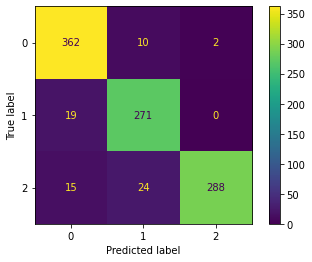

In [13]:
ConfusionMatrixDisplay.from_predictions(np.argmax(yTest, axis=1), np.argmax(yPred, axis=1))

### Class Activation Mapping

In [14]:
from skimage.transform import resize

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:
gap = model.layers[-2]
# model.get_layer(gap)
gap

In [17]:
pred_idx = 400
pred_class = np.argmax(yPred[pred_idx])

In [18]:
dense = model.layers[-1]
# model.get_layer(dense)
dense_weights = dense.get_weights()[0]
dense_weights[:,pred_class]

array([ 1.21580690e-01,  6.71288446e-02,  1.02679379e-01,  6.12919666e-02,
        8.29810556e-03, -9.82538536e-02, -7.47842640e-02, -1.23842573e-03,
        2.36651413e-02, -9.09903049e-02,  3.61719243e-02, -1.01681150e-01,
       -6.90601170e-02,  6.52393177e-02,  1.16142176e-01, -2.33382192e-02,
       -2.50906181e-02, -2.72618812e-02,  3.05982903e-02, -2.68043764e-02,
        1.04684591e-01, -1.00288324e-01, -1.13329060e-01,  5.15502617e-02,
       -4.29013185e-02, -1.14767931e-01, -2.21380242e-03, -6.98628575e-02,
        4.68520112e-02, -1.14167564e-01,  9.36038941e-02,  3.47494930e-02,
       -1.05632149e-01, -5.07592112e-02,  3.21575366e-02, -3.84036079e-03,
       -2.71293521e-02, -6.64919466e-02, -5.09163700e-02, -3.36661004e-02,
       -4.45538899e-03, -1.02386020e-01,  8.45410749e-02, -5.95996678e-02,
       -3.80698144e-02, -5.25092781e-02, -1.74133247e-03, -4.55605984e-02,
       -4.00977395e-02, -8.16571712e-02, -7.67852440e-02,  7.09772781e-02,
        7.33355209e-02, -

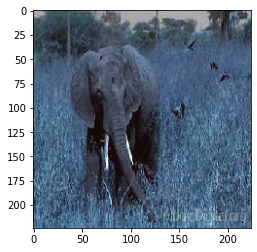

In [19]:
def display_img(disp_idx):
  """
  revert an image (roughly) back to before preprocessing
  """
  assert disp_idx <= xTest.shape[0], "index out of range"
  disp_im = xTest[disp_idx]
  disp_im_min = np.min(disp_im)
  disp_im_max = np.max(disp_im)
  assert disp_im_max != disp_im_min, "division by zero"
  disp_im = (disp_im - disp_im_min) / (disp_im_max - disp_im_min)
  plt.imshow(disp_im)
display_img(pred_idx)

In [20]:
# find predicted class
pred_class_weights = dense_weights[:,pred_class]
pred_class_weights.shape

(512,)

In [21]:
vgg_pred = VGGmodel.predict(xTest[pred_idx:pred_idx+1])[0]
vgg_pred.shape

1/1 [==============================] - 1s 801ms/step


(7, 7, 512)

In [22]:
vgg_pred.reshape(-1, 512).shape

(49, 512)

In [23]:
low_res_cam = np.dot(vgg_pred.reshape(-1, 512), pred_class_weights).reshape(7,7)

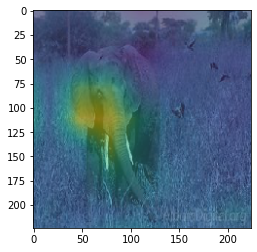

In [24]:
display_img(pred_idx)
plt.imshow(resize(low_res_cam, (224, 224)), alpha=0.5)